<a href="https://colab.research.google.com/github/VinniArst/Tugas-Machine-learning/blob/main/Final%20Exam_Mnist_HandWritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
n_epochs = 2  
batch_size_train = 64 
batch_size_test = 1000 
learning_rate = 0.03 
momentum = 0.7 
log_interval = 10 

random_seed = 1  
torch.backends.cudnn.enabled = False 
torch.manual_seed(random_seed) #

**PREPARING DATASETS**

In [4]:
train_loader = torch.utils.data.DataLoader( 
  torchvision.datasets.MNIST('/files/', train=True, download=True, 
                             transform=torchvision.transforms.Compose([#
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader( 
  torchvision.datasets.MNIST('/files/', train=False, download=True,#
                             transform=torchvision.transforms.Compose([# 
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

**PLOTTING**

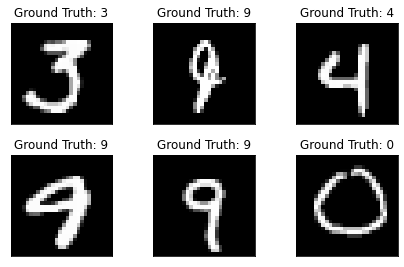

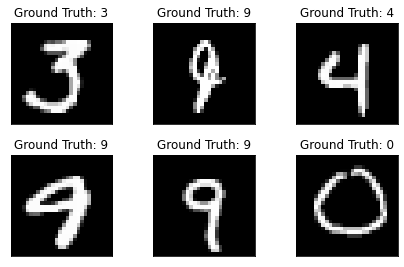

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding = 2) # input=28x28, 
        # conv = 24x24, padding = 26x26, pooling = 13x13  
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding = 1) 
        # input = 13x13, conv = 11x11, padding = 12x12, pooling = 6x6 
        # input pixel 28x28, conv = input pixel - kernel, padding = conv + padding, pooling = padding/jumlah pooling
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(6272, 256) #Dense layer
        self.fc2 = nn.Linear(256, 10)  #Dense Layer

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 6272)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
n_epochs = 4
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.0001
momentum = 0.5 
log_interval = 10

In [10]:
network = Net()
optimizer = optim.RMSprop(network.parameters(), lr=learning_rate, momentum = momentum)

# **TRAINING MODEL**

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3043, Accuracy: 987/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318936
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.196695
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.662171
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.471241
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.600357
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.439825
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.477466
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.397552
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.359482
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.470439
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.371737
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.278068
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.259058
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.210028
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.147924
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.213941
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.183442
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.204595
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.189587
Train Epoch: 1 [12160/

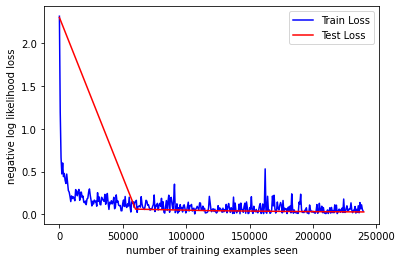

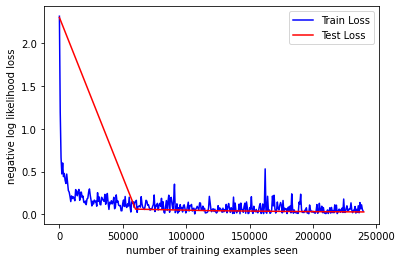

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

**TESTING MODEL**

In [16]:
with torch.no_grad(): #NO GRAD jikalau tidak ada gradient di testing, hanya ada di proses training
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


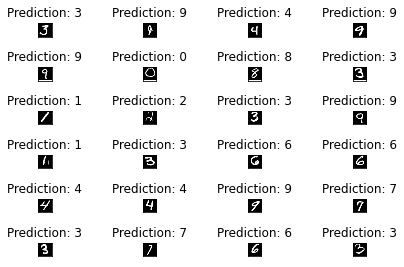

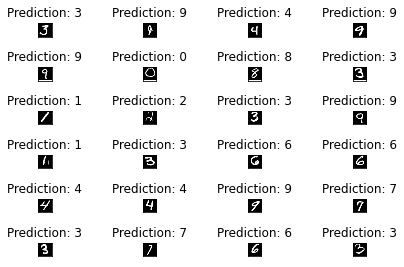

In [17]:
fig = plt.figure()
for i in range(24):
  plt.subplot(6,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig